In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import spacy
from spacy import displacy
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from textPreProcessor import *
from imagePreProcessor import *
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf

2023-06-13 10:24:21.789542: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


importing Jupyter notebook from textPreProcessor.ipynb
Original Date ----> After Processing 

5/12/22      ---->      5-12-2022
2/2/2023      ---->      2-2-2023
5:12-2023      ---->      5-12-2023
5,May,2023      ---->      5-05-2023
5 May,2023      ---->      5-05-2023
October 24,2022      ---->      10-24-2022
importing Jupyter notebook from imagePreProcessor.ipynb


In [4]:
pwd

'/home/aman/Documents/Tally/DocumentAI/Code/Tesseract-Modelv3'

In [5]:
os.chdir('/home/aman/Documents/Tally/DocumentAI/Code/Tesseract-Modelv3/Dataset/')

In [6]:
df = pd.read_csv("tesseract.csv")

In [7]:
df = df.loc[:99, :]

In [8]:
df.shape

(100, 32)

In [9]:
len(df["imageName"].unique())

73

In [10]:
def preProcess(df):
    for index in df.index:
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        Y = df["PageHeight"][index]
        
        if x<X//2:
            df["isLeft"][index]=1
        elif x>=X//2:
            df["isRight"][index]=1
            
        if y<Y//2:
            df["isBottom"][index]=1
        elif y>Y//2:
            df["isTop"][index]=1
            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]
    df["conf"]=df["conf"]/100
        
    colsToDrop = ["Unnamed: 0", "left", "top", "width", "height", "imageName", "text", "PageHeight", "PageWidth"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [11]:
preProcess(df)

/tmp/ipykernel_5163/419174630.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isLeft"][index]=1
/tmp/ipykernel_5163/419174630.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isBottom"][index]=1
/tmp/ipykernel_5163/419174630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_5163/419174630.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [12]:
df

,block_num,par_num,line_num,word_num,conf,x,y,isTop,isBottom,isRight,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
0,7,9,2,3,0.961913,0.275091,0.482257,0,1,0,...,1,0,1,0,0,0,0,0,0,0
1,7,9,3,4,0.957325,0.927449,0.499786,0,0,1,...,1,0,1,0,0,1,0,0,0,1
2,9,3,1,3,0.942344,0.406288,0.451475,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,9,3,1,4,0.846359,0.503628,0.454468,0,1,1,...,0,0,0,0,1,0,0,0,0,0
4,3,1,1,3,0.964914,0.832792,0.279823,0,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,23,1,9,7,0.962439,0.891863,0.347429,0,1,1,...,1,0,0,0,0,1,0,0,0,1
96,5,1,3,3,0.578870,0.474277,0.511450,1,0,0,...,1,0,0,0,0,0,0,0,0,1
97,13,1,1,2,0.578585,0.482906,0.921091,1,0,0,...,0,0,0,0,0,0,0,0,0,1
98,4,2,1,7,0.931823,0.902361,0.368101,0,1,1,...,1,0,0,0,0,1,0,0,0,1


In [13]:
df.describe()

,block_num,par_num,line_num,word_num,conf,x,y,isTop,isBottom,isRight,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000
mean,8.01000,1.570000,2.200000,3.410000,0.821875,0.623354,0.409011,0.15000,0.840000,0.630000,...,0.600000,0.040000,0.070000,0.020000,0.090000,0.440000,0.050000,0.050000,0.0,0.660000
std,5.25606,1.799298,2.291839,1.907428,0.159190,0.215145,0.148285,0.35887,0.368453,0.485237,...,0.492366,0.196946,0.256432,0.140705,0.287623,0.498888,0.219043,0.219043,0.0,0.476095
min,2.00000,1.000000,1.000000,1.000000,0.412293,0.115882,0.047273,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.00000,1.000000,1.000000,2.000000,0.745703,0.467749,0.338622,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,7.00000,1.000000,1.000000,3.000000,0.878924,0.626021,0.405379,0.00000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
75%,10.00000,1.000000,2.000000,4.000000,0.950633,0.833062,0.451780,0.00000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000
max,24.00000,14.000000,14.000000,12.000000,0.967962,0.953961,0.921091,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [117]:
df[df["output"]==1].shape

(66, 23)

In [118]:
df[df["output"]==0].shape

(34, 23)

In [14]:
df.corr()

,block_num,par_num,line_num,word_num,conf,x,y,isTop,isBottom,isRight,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
block_num,1.000000,-0.027311,-1.023011e-02,-0.111241,0.136439,0.148097,0.145382,0.090233,-0.082619,0.128202,...,-0.103824,-0.078454,-0.172894,0.095334,0.106304,-0.121111,-0.088174,-6.185352e-02,NaN,-0.261004
par_num,-0.027311,1.000000,-4.262131e-02,-0.045236,0.171532,-0.083284,0.340683,0.147828,-0.257189,-0.126221,...,-0.070691,-0.036486,0.328601,-0.045484,0.231680,0.089122,0.131990,-7.304277e-02,NaN,-0.054477
line_num,-0.010230,-0.042621,1.000000e+00,0.050372,-0.147714,0.001859,0.296389,0.282469,-0.284692,0.012716,...,-0.107417,-0.040281,-0.058437,-0.075176,-0.150170,-0.042405,-0.100605,6.527147e-18,NaN,-0.112940
word_num,-0.111241,-0.045236,5.037198e-02,1.000000,-0.148970,0.437183,-0.272525,-0.238315,0.223637,0.362000,...,0.219411,0.332343,0.043987,-0.030862,-0.031116,0.052650,0.047144,-7.373730e-02,NaN,0.077194
conf,0.136439,0.171532,-1.477139e-01,-0.148970,1.000000,-0.128532,-0.044364,-0.114538,0.088233,-0.069568,...,0.123460,-0.011084,0.025020,-0.021557,0.119141,0.187976,-0.039821,-9.355013e-02,NaN,-0.094694
x,0.148097,-0.083284,1.859230e-03,0.437183,-0.128532,1.000000,-0.269030,-0.191346,0.147621,0.822957,...,-0.041245,0.054328,-0.030122,-0.018170,-0.107707,-0.134256,-0.109848,4.256242e-02,NaN,0.094831
y,0.145382,0.340683,2.963892e-01,-0.272525,-0.044364,-0.269030,1.000000,0.725888,-0.723791,-0.276768,...,-0.256795,-0.346214,-0.134262,0.142015,-0.043643,0.034306,-0.130933,-7.689147e-02,NaN,-0.242842
isTop,0.090233,0.147828,2.824692e-01,-0.238315,-0.114538,-0.191346,0.725888,1.000000,-0.962533,-0.142115,...,-0.342997,-0.085749,-0.115251,0.140028,-0.034251,-0.203108,-0.096374,-9.637388e-02,NaN,-0.112328
isBottom,-0.082619,-0.257189,-2.846923e-01,0.223637,0.088233,0.147621,-0.723791,-0.962533,1.000000,0.117515,...,0.311805,0.089087,0.012829,-0.132489,0.041938,0.167053,0.100125,1.001252e-01,NaN,0.089828
isRight,0.128202,-0.126221,1.271614e-02,0.362000,-0.069568,0.822957,-0.276768,-0.142115,0.117515,1.000000,...,-0.160660,0.050735,-0.033283,-0.038466,-0.048491,-0.196948,-0.014255,8.077947e-02,NaN,-0.156531


In [15]:
df.shape

(100, 23)

In [16]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [17]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [18]:
xTrain.shape

(80, 22)

In [19]:
xTest.shape

(20, 22)

In [20]:
yTrain.shape

(80,)

In [21]:
type(xTrain)

numpy.ndarray

In [22]:
type(yTrain)

numpy.ndarray

In [111]:
model = keras.Sequential([
    keras.layers.Dense(8, input_shape=(22, ), activation='relu'),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [112]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 8)                 184       
                                                                 
 dense_37 (Dense)            (None, 4)                 36        
                                                                 
 dense_38 (Dense)            (None, 1)                 5         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [113]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy", 'Precision', "Recall", "TruePositives", "TrueNegatives", "FalsePositives", "FalseNegatives"])

In [114]:
history = model.fit(xTrain, yTrain,
          epochs=50, batch_size=1)

Epoch 1/50
80/80 [==============================] - 1s 870us/step - loss: 0.6987 - accuracy: 0.5875 - precision: 0.7273 - recall: 0.6038 - true_positives: 32.0000 - true_negatives: 15.0000 - false_positives: 12.0000 - false_negatives: 21.0000         
Epoch 2/50
80/80 [==============================] - 0s 1ms/step - loss: 0.6745 - accuracy: 0.6750 - precision: 0.7143 - recall: 0.8491 - true_positives: 45.0000 - true_negatives: 9.0000 - false_positives: 18.0000 - false_negatives: 8.0000                 
Epoch 3/50
80/80 [==============================] - 0s 906us/step - loss: 0.6601 - accuracy: 0.6750 - precision: 0.7077 - recall: 0.8679 - true_positives: 46.0000 - true_negatives: 8.0000 - false_positives: 19.0000 - false_negatives: 7.0000               
Epoch 4/50
80/80 [==============================] - 0s 904us/step - loss: 0.6501 - accuracy: 0.6625 - precision: 0.6806 - recall: 0.9245 - true_positives: 49.0000 - true_negatives: 4.0000 - false_positives: 23.0000 - false_negatives: 4.

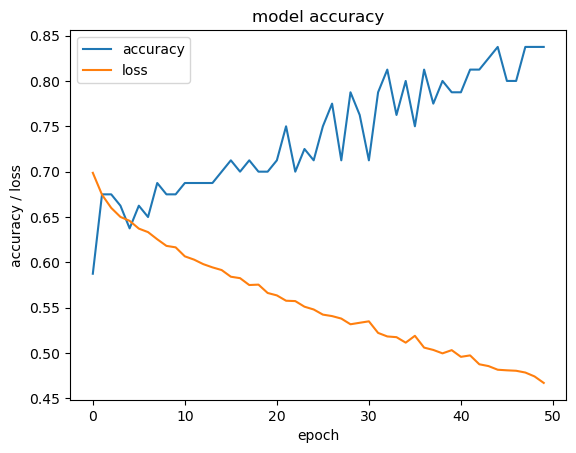

In [115]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.legend(["accuracy", "loss"])
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.show()

In [116]:
model.evaluate(xTest, yTest)

1/1 [==============================] - 0s 242ms/step - loss: 0.5169 - accuracy: 0.7500 - precision: 0.7222 - recall: 1.0000 - true_positives: 13.0000 - true_negatives: 2.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00


[0.5168519020080566, 0.75, 0.7222222089767456, 1.0, 13.0, 2.0, 5.0, 0.0]

In [97]:
pwd

'/home/aman/Documents/Tally/DocumentAI/Code/Tesseract-Modelv3/Models'

In [57]:
os.chdir('/home/aman/Documents/Tally/DocumentAI/Code/Tesseract-Modelv3/Models/')

In [ ]:
#model.save("tesseractv3.h5")